In [1]:
"""
The general method for the ARIMA implementation comes from:

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
"""

'\nThe general method for the ARIMA implementation comes from:\n\nhttps://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7\nhttps://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/\n'

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from sklearn import metrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from pmdarima import auto_arima

#Imported to ignore warnings from ARIMA
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
def read_data(pathname, indicatorcode):
    df = pd.read_excel(pathname)
    
    df2 = df.loc[df['Indicator Code'] == indicatorcode]
    
    #Dropping these columns as they are not needed for the forecast
    df2 = df2.drop(columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
    
    df3 = df2.swapaxes('index', 'columns')
    
    return df3

In [5]:
"""
Method for this block of code is refactored from both:

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
"""

def stationarityTest(data):
    
    #Find out if the data is stationary or not
    #Using Rolling Statistics (Rolling Mean and Rolling Std)
    rolling_mean = data.rolling(window=10).mean()
    rolling_std = data.rolling(window=10).std()
    
    plt.plot(data, color='blue', label='original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('RM vs RSTD vs ORI')
    
    #Augmented Dickey-Fuller Test
    result = adfuller(data.dropna())
    print('ADF Statistic: {}'.format(result[0]))
    #print(f'p-value: {result[1]}')
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

In [6]:
"""
Method 1 & 2 refactored from:

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

Method 3 refactored from:

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
"""

def make_stationary(data):
    
#There are multiple methods to make a time series stationary

#Method 1 - Subtracting the rolling mean
    rolling_mean = data.rolling(window=10).mean()
    data_minus = data - rolling_mean
    data_minus_dropped = data_minus.dropna(inplace=True)

#Method 2 - Exponential Decay
    exp_decay = data.ewm(halflife=10).mean()
    data_minus_ewm = data - exp_decay
    data_minus_ewm_dropped = data_minus_ewm.dropna(inplace=True)

#Method 3 - Differencing the series

#1st Order Differencing
    data_first_od = data.diff()
    data_first_od_dropped = data_first_od.dropna(inplace=True)
    
    return data_minus, data_minus_ewm, data_first_od

In [7]:
def performance_metrics(y_test, y_pred):
    
    sign1 = np.sign(np.array(y_test[1:]) - np.array(y_test[:-1]))
    sign2 = np.sign(np.array(y_pred[1:]) - np.array(y_pred[:-1]))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test )) *100
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    mda = np.mean((sign1 == sign2).astype(int))
    mean = np.mean(y_test)
    si = (rmse/mean)*100
    
    print("RMSE: ", rmse)
    print("MAPE: ", mape)
    print("MAE: ", mae)
    print("Scatter Index: ", si)
    print("MDA: ", mda)
    print("Mean of actual: ", mean)

In [8]:
data = read_data('/Users/farhanhabibie/Desktop/Farhan Thesis Code /UG-Project-Farhan/Indonesia Macro Dataset.xlsx', 
                     'NY.GDP.MKTP.KD.ZG')

In [9]:
data = data.dropna()

In [10]:
print(data.mean())

47    5.253679
dtype: float64


In [11]:
data_minus, data_minus_ewm, data_first_od = make_stationary(data)

ADF Statistic: -5.23070103191413
p-value: 0.000008
Critical Values:
	1%: -3.548493559596539
	5%: -2.912836594776334
	10%: -2.594129155766944


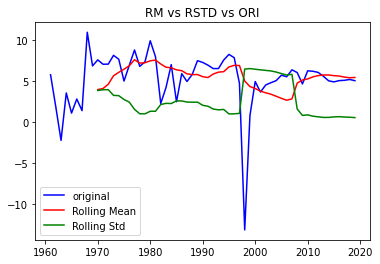

In [12]:
stationarityTest(data)

ADF Statistic: -4.762789223530919
p-value: 0.000064
Critical Values:
	1%: -3.5714715250448363
	5%: -2.922629480573571
	10%: -2.5993358475635153


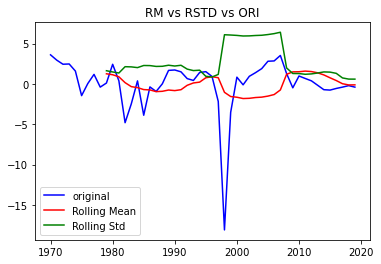

In [13]:
stationarityTest(data_minus)

ADF Statistic: -5.394741112043903
p-value: 0.000003
Critical Values:
	1%: -3.548493559596539
	5%: -2.912836594776334
	10%: -2.594129155766944


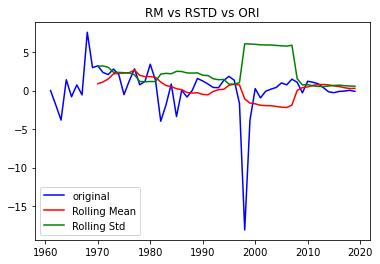

In [14]:
stationarityTest(data_minus_ewm)

ADF Statistic: -8.377325786351399
p-value: 0.000000
Critical Values:
	1%: -3.552928203580539
	5%: -2.9147306250000002
	10%: -2.595137155612245


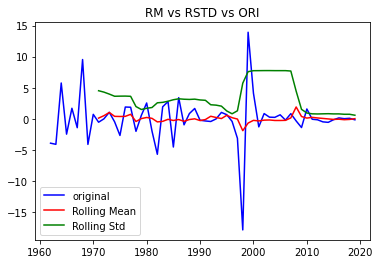

In [15]:
stationarityTest(data_first_od)

In [16]:
"""
Learned how to read PACF and ACF plots from 

https://towardsdatascience.com/identifying-ar-and-ma-terms-using-acf-and-pacf-plots-in-time-series-forecasting-ccb9fd073db8
"""

'\nLearned how to read PACF and ACF plots from \n\nhttps://towardsdatascience.com/identifying-ar-and-ma-terms-using-acf-and-pacf-plots-in-time-series-forecasting-ccb9fd073db8\n'

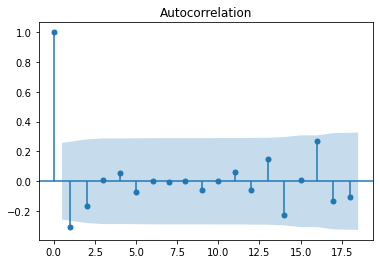

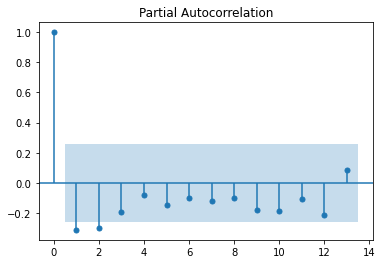

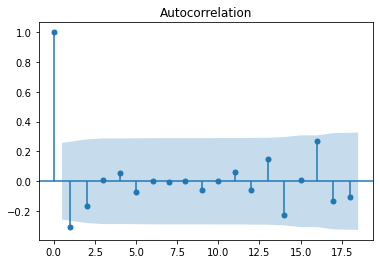

In [17]:
#Find AR order(p), differencing order(d), MA(q)

#Find AR order(p) using a PACF, only considering the 
plot_pacf(data_first_od.dropna(), lags=13)

#Find MA order (q) using acf plot
plot_acf(data_first_od.dropna())

In [18]:
test_size = len(data) - int(len(data) * 0.8)

train = data[:-test_size]
test = data[-test_size:]

In [26]:
model = ARIMA(train, order=(1,0,0))
model = model.fit()
predict = model.predict(start=len(train), end=len(train)+len(test)-1)

In [27]:
df_compare = pd.DataFrame({'Actual' : test.values.flatten(), 'Predicted' : predict.values})

In [28]:
newindex = test.index.values.tolist()
df_compare.index = newindex

<AxesSubplot:title={'center':'Unemployment (Female) Actual vs Predicted'}>

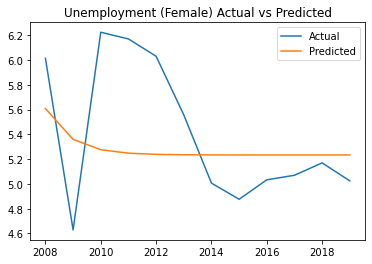

In [29]:
df_compare.plot(title='Unemployment (Female) Actual vs Predicted')

In [34]:
df_compare

,Actual,Predicted
2008,6.013704,5.607692
2009,4.628871,5.359561
2010,6.223854,5.276058
2011,6.169784,5.247957
2012,6.030051,5.238501
2013,5.557264,5.235318
2014,5.006668,5.234247
2015,4.876322,5.233887
2016,5.033069,5.233766
2017,5.069786,5.233725


In [31]:
performance_metrics(test.values, predict.values)

RMSE:  0.5378668577229616
MAPE:  8.623017497598878
MAE:  0.4452163744049731
Scatter Index:  9.959914379138402
MDA:  0.6363636363636364
Mean of actual:  5.400316079519256


In [25]:
"""
Idea for using pmdarima attributed to the video on youtube:

https://www.youtube.com/watch?v=8FCDpFhd1zk&ab_channel=NachiketaHebbar
"""

stepwise_fit = auto_arima(data, trace=True, suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=312.956, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=312.391, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=307.095, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=307.386, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=384.831, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=309.050, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=309.033, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=311.006, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=324.425, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.201 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -150.548
Date:                Mon, 18 Apr 2022   AIC                            307.095
Time:                        14:05:08   BIC                            313.328
Sample:                             0   HQIC                           309.528
                                 - 59                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4786      0.991      3.511      0.000       1.537       5.421
ar.L1          0.3381      0.191      1.767      0.077      -0.037       0.713
sigma2         9.6155      0.874     11.005      0.000       7.903      11.328
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               913.57
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                            -3.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1]:
"""
83 Lines of code
"""

'\n83 Lines of code\n'